<h1>Homework 04 - Applied ML</h1>

Importation of libraries

In [28]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
from functools import reduce
import math
from collections import Counter

Importation of the datas

In [29]:
filename = os.path.join('data','CrowdstormingDataJuly1st.csv') 
df = pd.read_csv(filename)
df.head(2)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504


A few numbers about the data:

In [30]:
print('Number of dyads (rows in dataframe): ', len(df))
print('Total number of interactions between a referee and a player (nb of games): ', sum(df.games))
print('Mean number of games for a dyad: ', np.mean(df['games']))

Number of dyads (rows in dataframe):  146028
Total number of interactions between a referee and a player (nb of games):  426572
Mean number of games for a dyad:  2.92116580382


## Data cleaning / setup

In [31]:
print("Number of rows in dataframe: ", len(df))

Number of rows in dataframe:  146028


<b>Removing raters</b>: We decided to remove row where the two rates were significantly different or if any of the rates were absent (Nan value).

In [32]:
cleandf = df.copy()

## Removing null values in raters
cleandf = cleandf[cleandf["rater1"].notnull() & cleandf["rater2"].notnull()]

## Removing all rows where the difference between the two raters is larger than 0.25
cleandf['difference'] = abs(cleandf.rater1 - cleandf.rater2)
cleandf = cleandf[cleandf['difference'] <= 0.25]
cleandf.drop('difference', axis =1, inplace=True)

print("Number of rows in the cleaned dataframe: ", len(cleandf))
print("Number of rows removed: ", (len(df)-len(cleandf)))

Number of rows in the cleaned dataframe:  124457
Number of rows removed:  21571


<b>Skin tone</b>: Then we decide to take the skin tone as the mean between the two raters. This is the value that will be predicted later.

In [33]:
cleandf["meanSkinTone"] = abs(cleandf["rater1"] + cleandf["rater2"] ) / 2
cleandf.head(2)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,meanSkinTone
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750


<b>Birthday date</b>: As the classifier can not understand date, we decided to change birthday date in seconds. It seemed important for us to keep the birthday date, as it could help predict the color skin if there were more people from a certain demography that played during some years.

In [34]:
def time_to_seconds(t):
    seconds = (pd.to_datetime(t) - datetime.datetime(1970, 1,1)).total_seconds()
    return int(seconds)

cleandf.birthday = cleandf.birthday.apply(time_to_seconds)
cleandf.head(2)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,meanSkinTone
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,431136000,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,397008000,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750


<h3>Changing data attributes to numerals function</h3>

<i>Dummy variables</i>: We noticed that a lot of the columns could not be used in the Random forest as they are non-numerical. As most of these features can be seen as categorical variables, we decided to make dummy variables with them.

In [35]:
print("The number of different positions is", cleandf["position"].unique().size)
print("The number of different clubs is",cleandf["club"].unique().size)
print("The number of different league countries is",cleandf["leagueCountry"].unique().size)
print("The number of different referee countries is",cleandf["Alpha_3"].unique().size)

The number of different positions is 13
The number of different clubs is 97
The number of different league countries is 4
The number of different referee countries is 160


Out of these datas, we decided to remove the "referee country" (Alpha_3) and to make dummy variables with the 3 other categories. We decided to remove the referee country because there were a lot of them and it seemed it would induce more error and overfitting to our classifier than it would help it.

<i>Replacing Nan</i>: We also realize that the dataframe still have some NaN values. We decided to substitute every NaN with the mean of their column.

In [36]:
cleandf.isnull().values.any()

True

Here is the function that will apply these changes:

In [37]:
def changeDfAttributesToNumerals(cleandf):
    ## Making the dummy variables
    dummydf = pd.get_dummies(cleandf, prefix=None, prefix_sep='_', dummy_na=False, columns=["position"], sparse=False, drop_first=False)
    dummydf = pd.get_dummies(dummydf, prefix=None, prefix_sep='_', dummy_na=False, columns=["club"], sparse=False, drop_first=False)
    dummydf = pd.get_dummies(dummydf, prefix=None, prefix_sep='_', dummy_na=False, columns=["leagueCountry"], sparse=False, drop_first=False)
    dummydf.drop("Alpha_3", axis = 1, inplace = True)
    
    ## Replacing NaN values
    # For each column, if there is any NaN value, we compute the mean and replace the NaN values with it.
    for i in range(len(dummydf.columns)):
        if (dummydf[dummydf.columns[i]].isnull().values.any()):
            mean = np.mean(dummydf[dummydf.columns[i]])
            dummydf[dummydf.columns[i]].fillna(mean, inplace = True)
    
    return dummydf

We can now apply the function to our dataset and observe the results:

In [38]:
dummydf = changeDfAttributesToNumerals(cleandf)
print("Number of columns in the previous dataframe: ",cleandf.columns.size)
print("Number of columns in the new dataframe with dummy variables: ",dummydf.columns.size)

Number of columns in the previous dataframe:  29
Number of columns in the new dataframe with dummy variables:  138


In [39]:
dummydf.isnull().values.any()

False

<b>Removing useless columns</b>: For the classifier, there are some columns that it makes no sense to use. These columns are the player name (and short name), the photo and the initial ratings (of rater 1 and 2). Therefore we will drop them.

In [40]:
usedf = dummydf.drop(['playerShort', 'player', 'photoID', 'rater1', 'rater2']  , axis=1)

In [41]:
usedf.head(3)

,birthday,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,...,club_Werder Bremen,club_West Bromwich Albion,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Évian Thonon Gaillard,leagueCountry_England,leagueCountry_France,leagueCountry_Germany,leagueCountry_Spain
0,431136000,177.0,72.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,397008000,179.0,82.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,303177600,182.0,71.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Classifier

First, we executed the random forest classification algorithm.

We decided to go with multiclass classification. As it was asked to predict the skin color, this looked like it was going to be the most interesting way of observing the classification. Of course, this implies that the error will be a lot larger than in the case of binary classification.

In the following part, we built a function that executed random forest. It directly does the kfold validation with a decided K = 5. This looked enough to test it and not have a running time that was too long. Of course this value could be augmented for more precise result, but we didn't see a big enough difference that it seemed worth it.

To compute the score, we decided to go with a simple accuracy score. We didn't implement our own scoring function, but this should be adapted to f1 score (for example) in case of binary class, to equilibrate with the number of sample that we have for each data

We have different parameters:<br>
X: The data that will try to fit<br>
y: The row that contains the meanSkinColor, that we will try to fit as best as possible<br>
Xpd: The dataframe containing X<br>
printingInfo: boolean if we want to print information<br>
numb_trees: A parameter of the random forest classification that we will vary. It contains the number of trees that we want to use in our algorithm.<br>
nb_features: A parameter of the random forest classification that we will vary. It contains the maximum number of features to we want to use.

In [42]:

def executingRandomForest(X, y, Xpd, printingInfo, numb_trees, nb_features, maxdepth):
    # Creating kfolds
    once = True
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    sumAccurancy_tr = 0
    sumAccurancy_te = 0

    #Iterating for kfold validation
    for train_index, test_index in kf.split(X):
        if(once):
            print("Train/Test sample sizes:", train_index.size, " / ", test_index.size)

        ## Making indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #Make classifier
        rf = RandomForestClassifier(n_estimators = numb_trees, max_features = nb_features,  max_depth = maxdepth, n_jobs = 4)

        #Train the classifier
        clf = rf.fit(X_train, y_train)

        # Make prediction for testing data with the classifier
        y_pred = clf.predict(X_test)

        #Computing error
        rf_train_score = metrics.accuracy_score(y_train, clf.predict(X_train))
        rf_test_score = metrics.accuracy_score(y_test, y_pred)
        if(printingInfo):
            print('Train/Test:  {:.4f} / {:.4f}'.format(rf_train_score, rf_test_score))
#             print('   {:.4f}'.format(rf_test_score))
        
        sumAccurancy_tr = sumAccurancy_tr + rf_train_score
        sumAccurancy_te = sumAccurancy_te + rf_test_score


        # Features importance score
        if(once):
            once = False
            importances = rf.feature_importances_
            std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                         axis=0)
            indices = np.argsort(importances)[::-1]

    #Printing the final result score:
    print('=> Final Train/Test:  {:.4f} / {:.4f}'.format(sumAccurancy_tr / 5.0, sumAccurancy_te / 5.0))
    
    if(printingInfo):
        # Plot the feature importances of the forest
        fig = plt.figure()
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
                   color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), importances[indices])
        plt.xlim([-1, X.shape[1]])
        plt.show()

        # Print the feature ranking
        print("Feature ranking (first 20):")
        for f in range(20):
            print("%d. feature %s (%f)" % (f + 1, Xpd.columns[f], importances[indices[f]]))
        
    # Returns the average accurancy for the testing set and the training set
    return (sumAccurancy_tr / 5.0, sumAccurancy_te / 5.0)

This function takes a dataframe, and will make all the parameters that are needed in the random forest function.<br>
<i>X (the features to use in the classifier) and Y (the value to predict).</i>

In [43]:
def makeMatrixForClassifier(df):
    y = np.asarray(df["meanSkinTone"].values, dtype="|S6")
    Xpd = df.drop("meanSkinTone", axis = 1)
    X = Xpd.as_matrix()
    return (X, y, Xpd)

We will execute a first time the algorithm:

Train/Test sample sizes: 99565  /  24892
Train/Test:  0.9999 / 0.9892
Train/Test:  0.9999 / 0.9948
Train/Test:  0.9999 / 0.9936
Train/Test:  0.9998 / 0.9911
Train/Test:  0.9999 / 0.9939
=> Final Train/Test:  0.9999 / 0.9925


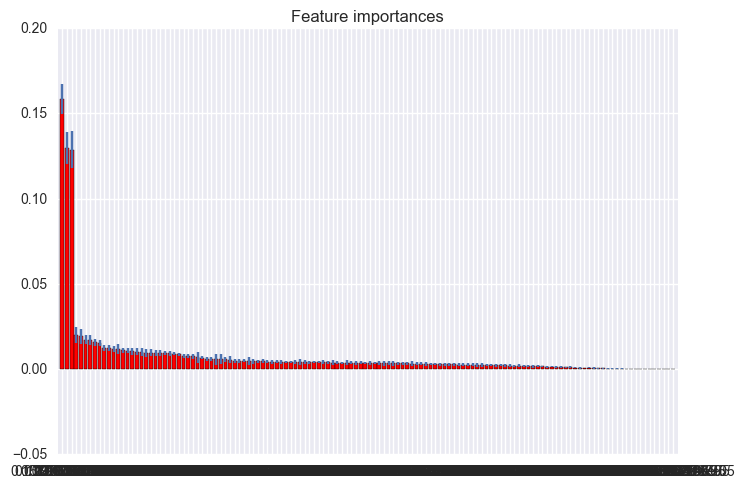

Feature ranking (first 20):
1. feature birthday (0.158261)
2. feature height (0.129761)
3. feature weight (0.128663)
4. feature games (0.020051)
5. feature victories (0.019178)
6. feature ties (0.017283)
7. feature defeats (0.016842)
8. feature goals (0.015614)
9. feature yellowCards (0.015334)
10. feature yellowReds (0.012388)
11. feature redCards (0.012178)
12. feature refNum (0.011729)
13. feature refCountry (0.011647)
14. feature meanIAT (0.011079)
15. feature nIAT (0.010710)
16. feature seIAT (0.010300)
17. feature meanExp (0.010211)
18. feature nExp (0.009994)
19. feature seExp (0.009493)
20. feature position_Attacking Midfielder (0.009474)


(0.99990558993893686, 0.99249540853657869)

In [44]:
numb_trees = 10
nb_features = "auto"
(X, y, Xpd) = makeMatrixForClassifier(usedf)
executingRandomForest(X, y, Xpd, True, numb_trees, nb_features, None)

We can observe that we have unrealistic results. 99% accuracy for both training and testing sets seem too good to be true. When we look at the features importance result, we can quickly see what went wrong. The 3 most important features are the birthday, the height and the weight. It makes sense, because what is actually happening, is that the classifier has more than one line per person. Therefore, as a person has always the same skin color, recognizing the person leads to know its skin color.<br>
The testing set also has amazing result, as there are enough data of person to find them in both sets. Let's try to see if we can correct this by removing the main features.

In [157]:
betterResultMaybedf = usedf.drop(['birthday', 'height', 'weight']  , axis=1)
(X, y, Xpd) = makeMatrixForClassifier(betterResultMaybedf)
executingRandomForest(X, y, Xpd, True, numb_trees, nb_features, None)

Train/Test sample sizes: 99565  /  24892
Train/Test:  0.9722 / 0.6966
Train/Test:  0.9726 / 0.6952
Train/Test:  0.9725 / 0.7026
Train/Test:  0.9728 / 0.7055
Train/Test:  0.9721 / 0.6970
=> Final Train/Test:  0.9724 / 0.6994
Feature ranking (first 20):
1. feature games (0.141428)
2. feature victories (0.048816)
3. feature ties (0.045265)
4. feature defeats (0.037709)
5. feature goals (0.033544)
6. feature yellowCards (0.029875)
7. feature yellowReds (0.026986)
8. feature redCards (0.024411)
9. feature refNum (0.023693)
10. feature refCountry (0.021943)
11. feature meanIAT (0.021562)
12. feature nIAT (0.020239)
13. feature seIAT (0.020109)
14. feature meanExp (0.019153)
15. feature nExp (0.017244)
16. feature seExp (0.017177)
17. feature position_Attacking Midfielder (0.016737)
18. feature position_Center Back (0.016625)
19. feature position_Center Forward (0.016461)
20. feature position_Center Midfielder (0.016029)


(0.97240412335450588, 0.69935806699243097)

We can observe that the result is a bit worse for the testing data, as the algorithm has more trouble to "recognize" players. However, the real problem remains, and we will therefore need to find a way to group the players together. What we will want at the end, is to have a single player per line, with aggregated data in its fields. Let's see how we are going to do this.

## Aggregate the referee info by socker player

We found that there were different ways that we will aggregate the data. And, in order to aggregate the referee info, we preprocessed the data in the following way:

<ul>
<li> One occurrence data - the data that doesn't change (constants): <b>const_columns</b></li>
<li> Accumulated data - e.g. victories, yellowCards, etc. :
<b>acc_columns</b></li>
<li> Majority voting - most frequent data:
<b>majority_vote</b></li>
<li> Removed data - insignificant columns:
<b>remove_columns</b></li>

In [158]:
acc_columns = ['games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
const_columns = ['playerShort', 'player', 'birthday', 'height', 'weight', 'meanSkinTone']
majority_vote = ['club', 'leagueCountry', 'position']

In [159]:
# we remove rater1 and rater2 because we already have calculated 'meanSkinTone' as the mean between those two raters
remove_columns = ['photoID', 'refNum', 'refCountry', 'Alpha_3', 'rater1', 'rater2']
referee_info_df = cleandf.drop(remove_columns, axis = 1)

#### After cleaning up, we group the data by player short name

In [160]:
by_group_player = list(referee_info_df.groupby('playerShort'))

In [161]:
# auxiliary function used in order to accumulate values for columns in 'acc_columns'
sum_func = lambda x, y: x+y
def accumulate(series):
    return reduce(sum_func, series)

<h3> Direct aggregation of data</h3>

We have the function to compute the weight. We can observe that the IAT and Exp scores are computed using statistical formulas weighted by the number of samples.

In [162]:
# Having various means, we want to combine - so we average them via calculating weighted mean 
# (the weight is the sample size)

def get_weighted_mean(data):
    
    # weighted mean calculation for meanIAT
    acc_niat = accumulate(data['nIAT'].tolist())
    acc_prod_iat = accumulate((data['meanIAT']*data['nIAT']).tolist())
    
    # weighted mean calculation for meanExp
    acc_nexp = accumulate(data['nExp'].tolist())
    acc_prod_exp = accumulate((data['meanExp']*data['nExp']).tolist())
    
    # squareroot of weighted mean of the square for seIAT
    acc_se_iat =accumulate((data['nIAT']).tolist())
    acc_prod_se_iat = accumulate((data['seIAT']*data['seIAT']*data['nIAT']).tolist())
    
    # squareroot of weighted mean of the square for seExp
    acc_se_exp =accumulate((data['nExp']).tolist())
    acc_prod_se_exp = accumulate((data['seExp']*data['seExp']*data['nExp']).tolist())
    
    return {'weighted_mean_iat' : acc_prod_iat/acc_niat,
              'weighted_mean_exp' : acc_prod_exp/acc_nexp,
              'sqrt_weighted_mean_iat' : math.sqrt(acc_prod_se_iat/acc_se_iat),
              'sqrt_weighted_mean_exp' : math.sqrt(acc_prod_se_iat/acc_se_iat)}

We execute the aggregation functions.

In [163]:
# we aggregate data in the format of 'list[dict()]' in order to create DataFrame
unique_player_data = [] 

# iterating over the grouped by plater data we assemble all processed values into the dictionary - a row within
# an out DataFrame
for player_name, data in by_group_player:
    
    # constants - we keep just first value from every column
    one_occurrence = { column : data[column].tolist()[0] for column in const_columns }
    
    #accumulated values
    accumulated = {column : accumulate(data[column].tolist()) for column in acc_columns}
    
    # majority voting = most_common() gives descending ordered by count, list of pairs;
    # most_common()[0][0] - first 0 stands for max voted value ('name': count)
    #                       second 0 gives it's name - first element from tuple 
    majority_vote = { column : Counter(data[column].tolist()).most_common()[0][0] for column in majority_vote}

    # weighted mean calculation
    wm = get_weighted_mean(data)
    
    # assemble just calculated data into one dictionary
    unique_player_data.append(
        dict(list(one_occurrence.items()) +
             list(accumulated.items()) +
             list(majority_vote.items()) +
             list(wm.items())))

In [164]:
# create DataFrame from aggregated data
aggregated_df = pd.DataFrame(unique_player_data)

We clean again the datas:

In [165]:
aggregated_df = pd.get_dummies(aggregated_df, prefix=None, prefix_sep='_', dummy_na=False, columns=["position"], sparse=False, drop_first=False)
aggregated_df = pd.get_dummies(aggregated_df, prefix=None, prefix_sep='_', dummy_na=False, columns=["club"], sparse=False, drop_first=False)
aggregated_df = pd.get_dummies(aggregated_df, prefix=None, prefix_sep='_', dummy_na=False, columns=["leagueCountry"], sparse=False, drop_first=False)
randomForestDF = aggregated_df.drop(['player', 'playerShort'], axis = 1)
# For each column, if there is any NaN value, we compute the mean and replace the NaN values with it.
for i in range(len(randomForestDF.columns)):
    if (randomForestDF[randomForestDF.columns[i]].isnull().values.any()):
        mean = np.mean(randomForestDF[randomForestDF.columns[i]])
        randomForestDF[randomForestDF.columns[i]].fillna(mean, inplace = True)
randomForestDF.isnull().values.any()

False

<b>New execution:</b> Now, we can execute again the classifier with the new datas.

In [166]:
(X, y, Xpd) = makeMatrixForClassifier(randomForestDF)
executingRandomForest(X, y, Xpd, True, 10, "auto", None)

Train/Test sample sizes: 1266  /  317
Train/Test:  0.9826 / 0.3091
Train/Test:  0.9834 / 0.3312
Train/Test:  0.9850 / 0.3028
Train/Test:  0.9874 / 0.2722
Train/Test:  0.9811 / 0.2627
=> Final Train/Test:  0.9839 / 0.2956
Feature ranking (first 20):
1. feature birthday (0.062119)
2. feature defeats (0.060191)
3. feature games (0.060101)
4. feature goals (0.058542)
5. feature height (0.054500)
6. feature redCards (0.053184)
7. feature sqrt_weighted_mean_exp (0.052255)
8. feature sqrt_weighted_mean_iat (0.051065)
9. feature ties (0.050727)
10. feature victories (0.050103)
11. feature weight (0.049562)
12. feature weighted_mean_exp (0.049057)
13. feature weighted_mean_iat (0.047486)
14. feature yellowCards (0.027897)
15. feature yellowReds (0.025444)
16. feature position_Attacking Midfielder (0.009118)
17. feature position_Center Back (0.009090)
18. feature position_Center Forward (0.008968)
19. feature position_Center Midfielder (0.008662)
20. feature position_Defensive Midfielder (0.0081

(0.98389124338693601, 0.29560555843948411)

We can observe that we overfit, however the results seem much more realistic. We get 30% for the testing set, which seems good considering that we have 9 classes. The only strange part is the feature "birthday" that goes on top but it is not something we want.

In [167]:
newRandomForestDF = randomForestDF.drop(['birthday', 'height', 'weight']  , axis=1)
(X, y, Xpd) = makeMatrixForClassifier(newRandomForestDF)
executingRandomForest(X, y, Xpd, True, 10, "auto", None)

Train/Test sample sizes: 1266  /  317
Train/Test:  0.9747 / 0.3091
Train/Test:  0.9866 / 0.2650
Train/Test:  0.9834 / 0.3249
Train/Test:  0.9905 / 0.3006
Train/Test:  0.9826 / 0.2911
=> Final Train/Test:  0.9836 / 0.2982
Feature ranking (first 20):
1. feature defeats (0.076111)
2. feature games (0.069234)
3. feature goals (0.065894)
4. feature redCards (0.064736)
5. feature sqrt_weighted_mean_exp (0.063384)
6. feature sqrt_weighted_mean_iat (0.062530)
7. feature ties (0.062174)
8. feature victories (0.059572)
9. feature weighted_mean_exp (0.057768)
10. feature weighted_mean_iat (0.057632)
11. feature yellowCards (0.033636)
12. feature yellowReds (0.031213)
13. feature position_Attacking Midfielder (0.013634)
14. feature position_Center Back (0.010527)
15. feature position_Center Forward (0.010401)
16. feature position_Center Midfielder (0.010206)
17. feature position_Defensive Midfielder (0.009279)
18. feature position_Goalkeeper (0.008810)
19. feature position_Left Fullback (0.007904)

(0.98357453950132856, 0.29816515593179732)

We observe no improvement of the score, however the features selection look more realistic.

## Parameters effect on the random forest

### Number of trees

In [168]:
nb_features = len(randomForestDF.columns)
nb_trees = 200

In [169]:
training = []
testing = []

for i in range(10, nb_trees, 10):
    tr, te = executingRandomForest(X, y, Xpd, False, i, "auto", None)
    training.append(tr)
    testing.append(te)

Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9809 / 0.3039
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9978 / 0.3070
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9994 / 0.3228
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3297
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3272
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3285
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3291
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3323
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3342
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3323
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3379
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3474
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  1.0000 / 0.3411
Train/Test s

In [170]:
import matplotlib.pyplot as plt
axis = range(10, nb_trees, 10)
tr = np.array(training)
te = np.array(testing)
plt.plot(tr)
plt.plot(te)
plt.show()

As we can see, our model overfits more and more with the number of trees. It is normal as it is increasing the complexity of the model. It is also important to notice that the accurancy of the testing set increases as well, but slower.

### Number of features

In [171]:
del training[:]
del testing[:]

for i in range(1, nb_features, 10):
    tr, te = executingRandomForest(X, y, Xpd, False, 10, i, None)
    training.append(tr)
    testing.append(te)

Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9844 / 0.3070
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9848 / 0.2906
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9829 / 0.3083
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9840 / 0.3127
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9796 / 0.3026
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9803 / 0.2969
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9793 / 0.3045
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9831 / 0.3102
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9798 / 0.2975
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9809 / 0.3102
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9804 / 0.2868
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9814 / 0.3108
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.9807 / 0.3095


In [172]:
axis = range(10, nb_features, 10)
tr = np.array(training)
te = np.array(testing)
plt.plot(tr)
plt.plot(te)
plt.show()

The accurancy af the testing set increases with the accurancy of the training set until 6 features. So it is not necessary to take more than 6 features. Indeed, according to the score given to columns to guess player's skine tone, the six first were quite far away from the others.

### Max depth

In [173]:
del training[:]
del testing[:]

for i in range(1, 10, 1):
    tr, te = executingRandomForest(X, y, Xpd, False, 10, "auto", i)
    training.append(tr)
    testing.append(te)

Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.3312 / 0.3177
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.3422 / 0.3278
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.3643 / 0.3405
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.3801 / 0.3418
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.4037 / 0.3360
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.4371 / 0.3373
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.4706 / 0.3411
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.5118 / 0.3373
Train/Test sample sizes: 1266  /  317
=> Final Train/Test:  0.5548 / 0.3374


In [174]:
axis = range(10, 10, 1)
tr = np.array(training)
te = np.array(testing)
plt.plot(tr)
plt.plot(te)
plt.show()

We can observe that until a max depth of 2 the accurancy of the testing set is increasing. So we can decide to use a max depth of 2.

In [175]:
(X, y, Xpd) = makeMatrixForClassifier(randomForestDF)

y = y.astype(float)
for i in range(len(y)):
    if (y[i] <= 0.5):
        y[i] = 1
    else:
        y[i] = 0

def clustering(X, y):        
    kmeans = KMeans(n_clusters=2, random_state=0)
    y_pred = kmeans.fit_predict(X)
    
    f1score = metrics.f1_score(y, y_pred)
    print('Score f1_score: {:.5f}'.format(f1score))
    score = metrics.accuracy_score(y, y_pred)
    print('Score accuracy_score: {:.5f}'.format(1-score))
    return f1score

# clustering(X,y)

In [176]:
cols = []

kmeansDF = randomForestDF.copy()
(X, y, Xpd) = makeMatrixForClassifier(kmeansDF)

y = y.astype(float)
for i in range(len(y)):
    if (y[i] <= 0.5):
        y[i] = 1
    else:
        y[i] = 0

scores = []
for i in range(randomForestDF.columns.size - 1):
    print(i, ': ', Xpd.columns[i])
    kmeansTemp = Xpd.drop(Xpd.columns[i], axis=1)
    X = kmeansTemp.as_matrix()
    sc = clustering(X,y)
    scores.append(sc)


0 :  birthday
Score f1_score: 0.47383
Score accuracy_score: 0.60328
1 :  defeats
Score f1_score: 0.60394
Score accuracy_score: 0.50790
2 :  games
Score f1_score: 0.60394
Score accuracy_score: 0.50790
3 :  goals
Score f1_score: 0.60394
Score accuracy_score: 0.50790
4 :  height
Score f1_score: 0.60394
Score accuracy_score: 0.50790
5 :  redCards
Score f1_score: 0.60394
Score accuracy_score: 0.50790
6 :  sqrt_weighted_mean_exp
Score f1_score: 0.60394
Score accuracy_score: 0.50790
7 :  sqrt_weighted_mean_iat
Score f1_score: 0.60394
Score accuracy_score: 0.50790
8 :  ties
Score f1_score: 0.60394
Score accuracy_score: 0.50790
9 :  victories
Score f1_score: 0.60394
Score accuracy_score: 0.50790
10 :  weight
Score f1_score: 0.60394
Score accuracy_score: 0.50790
11 :  weighted_mean_exp
Score f1_score: 0.60394
Score accuracy_score: 0.50790
12 :  weighted_mean_iat
Score f1_score: 0.60394
Score accuracy_score: 0.50790
13 :  yellowCards
Score f1_score: 0.60394
Score accuracy_score: 0.50790
14 :  yel

# Clustering

We decided to use the KMeans classifier for clustering. It seemed to be the best algorithm to use, because we know the number of clusters that we want to have, and the parameters are simple enough to make.

We first make the parameters right, and then make a clustering function.

In [177]:
(X, y, Xpd) = makeMatrixForClassifier(randomForestDF)


In [178]:
y = y.astype(float)
for i in range(len(y)):
   if (y[i] <= 0.5):
       y[i] = 1
   else:
       y[i] = 0

In [179]:
def clustering(X, y):        
   kmeans = KMeans(n_clusters=2, random_state=0)
   y_pred = kmeans.fit_predict(X)
   
   f1score = metrics.f1_score(y, y_pred)
   score = metrics.accuracy_score(y, y_pred)
   return (f1score, score)



In [180]:
(f1score,score) = clustering(X,y)
print('Score accuracy_score: {:.5f}'.format(score))
print('Score f1_score: {:.5f}'.format(f1score))

Score accuracy_score: 0.49210
Score f1_score: 0.60394


We can see that the result it not so good.


We will next try to remove iteratively some features, so that we can see if this changes something. As we have 129 columns, the combination of all of this columns lead to a number far too big to try all the combinations. Therefore we tried 2 strategies: First to keep all columns except one that we change each time. Secondly to remove all columns one after the other.

In [181]:
cols = []

kmeansDF = randomForestDF.copy()
(X, y, Xpd) = makeMatrixForClassifier(kmeansDF)

y = y.astype(float)
for i in range(len(y)):
    if (y[i] <= 0.5):
        y[i] = 1
    else:
        y[i] = 0

scores = []
for i in range(randomForestDF.columns.size - 1):

    kmeansTemp = Xpd.drop(Xpd.columns[i], axis=1)
    X = kmeansTemp.as_matrix()
    (sc, sc2) = clustering(X,y)
    scores.append(sc)
    print(i, ': ', Xpd.columns[i])
    print('Score f1_score: {:.5f}'.format(f1score))
print(scores)

0 :  birthday
Score f1_score: 0.60394
1 :  defeats
Score f1_score: 0.60394
2 :  games
Score f1_score: 0.60394
3 :  goals
Score f1_score: 0.60394
4 :  height
Score f1_score: 0.60394
5 :  redCards
Score f1_score: 0.60394
6 :  sqrt_weighted_mean_exp
Score f1_score: 0.60394
7 :  sqrt_weighted_mean_iat
Score f1_score: 0.60394
8 :  ties
Score f1_score: 0.60394
9 :  victories
Score f1_score: 0.60394
10 :  weight
Score f1_score: 0.60394
11 :  weighted_mean_exp
Score f1_score: 0.60394
12 :  weighted_mean_iat
Score f1_score: 0.60394
13 :  yellowCards
Score f1_score: 0.60394
14 :  yellowReds
Score f1_score: 0.60394
15 :  position_Attacking Midfielder
Score f1_score: 0.60394
16 :  position_Center Back
Score f1_score: 0.60394
17 :  position_Center Forward
Score f1_score: 0.60394
18 :  position_Center Midfielder
Score f1_score: 0.60394
19 :  position_Defensive Midfielder
Score f1_score: 0.60394
20 :  position_Goalkeeper
Score f1_score: 0.60394
21 :  position_Left Fullback
Score f1_score: 0.60394
22 


We can observe that the plot seems to lead to no special result, which looks strange